# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Importar librerías de código

In [428]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Nothing done.


#### Dataset que se va a utilizar para el entrenamiento

In [429]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
valor_min = 0
valor_max = 256     #256 porque el valor máximo es exclusivo, es decir, irá de 0 a 255
valores_color = 3
num_colores = 100
datos = np.random.randint(valor_min, valor_max, (num_colores, valores_color))








## SOM Setup
#### Variables definidas por el alumno

In [430]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 30
periodo = 4000
learning_rate = 0.30

normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [431]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.

num_entradas = len(datos[0])   #Usamos len para contar el numero de filas y columnas
num_datos = len(datos)
     
#Función para escoger un patrón de entrada aleatorio
def obtener_Entrada(datos):
   valor_aleatorio = np.random.randint(0,100)
   return datos[valor_aleatorio]

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
# Calculamos el valor maximo de la matriz

valor_maximo = 0
for dato in datos:
    for valor in dato:
        if(valor_maximo < valor):
            valor_maximo = valor  

      
if normalizar_datos:
    datos = datos/valor_maximo   
    
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
#matriz_pesos = np.random.random((dimensiones de la matriz de pesos))

matriz_pesos = np.random.random((lado_mapa*lado_mapa,num_entradas))



#### Funciones para entrenar/clasificar

In [432]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""

def calcular_bmu(patron_entrada, matriz_pesos, m):
   
   """
    Diferencias es un array de 3 elementos que tendrá el cuadrado de la resta de la entrada menos el peso para calcular la distancia euclídea que
    terminará calculándose en distancia local haciendo la raíz de la suma de los valores anteriores.
   
   """
   distancia_local = 0                      
   distancia_minima = float('inf')
   diferencias = np.zeros(m)
   bmu = []
   bmu_idx = ()

   for i in range(len(matriz_pesos)):
      for j in range(m):
         diferencias[j] = (patron_entrada[j] - matriz_pesos[i,j]) ** 2
      """

      Distancia local tendrá la distancia que se esté calculando en el momento, es decir, en la primera iteración tendrá la distancia de la 
      neurona 0,0 al patrón de entrada, después la de 0,1 y así sucesivamente.
      Si la distancia local es menor que la distancia mínima consideraremos esa neurona como la bmu. En la primera iteración la primera neurona 
      será la bmu ya que distancia mínima está inicializada a infinito.
      
      """
      distancia_local = np.sqrt(np.sum(diferencias))
      if(distancia_local < distancia_minima):
         distancia_minima = distancia_local
         bmu = matriz_pesos[i]
         bmu_idx = (i//lado_mapa,i%lado_mapa)
         posicion = i
   # Por último retornamos la bmu , su posición en el mapa y su posición en la matriz
   return bmu, bmu_idx, posicion
           
patron_entrada = obtener_Entrada(datos)     
bmu, bmu_idx, posicion = calcular_bmu(patron_entrada, matriz_pesos, num_entradas)
print(f"El patrón de entrada es:\n",patron_entrada)
print(f"Y la BMU es:")
print(f"Valor:",bmu,"\nCordenadas:",bmu_idx, "Posicion:",posicion)

    
    

El patrón de entrada es:
 [0.54509804 0.99215686 0.78823529]
Y la BMU es:
Valor: [0.60225093 0.97221054 0.77445775] 
Cordenadas: (2, 0) Posicion: 60


In [433]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
#Aplicamos la función para calcular la variación de lr
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    return lr_inicial * (1-(i/n_iteraciones)) 

In [434]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   return 1 + vecindario_inicial * (1-(i/n_iteraciones))

In [435]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU / (2* (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [436]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores, titulo):
    
    # Reformateamos la matriz de pesos de (625, 3) a (25, 25, 3)
    mapa_colores = matriz_valores.reshape((lado_mapa, lado_mapa, 3))
    # Mostramos la imagen con los colores RGB
    plt.figure(figsize=(6, 6))
    plt.imshow(mapa_colores, aspect='equal')
    plt.title(titulo)
    plt.axis("off")  # Quitamos los ejes para mejor visualización
    plt.show()





## SOM Entrenamiento

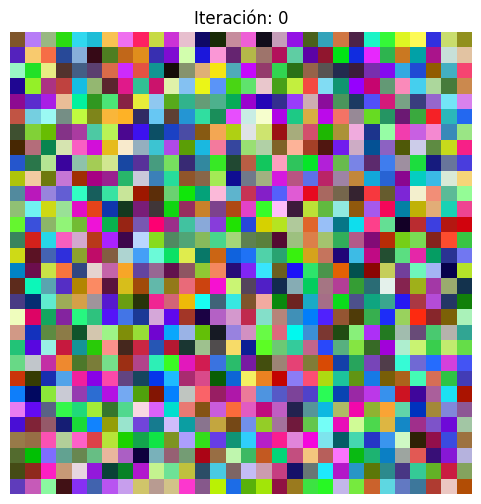

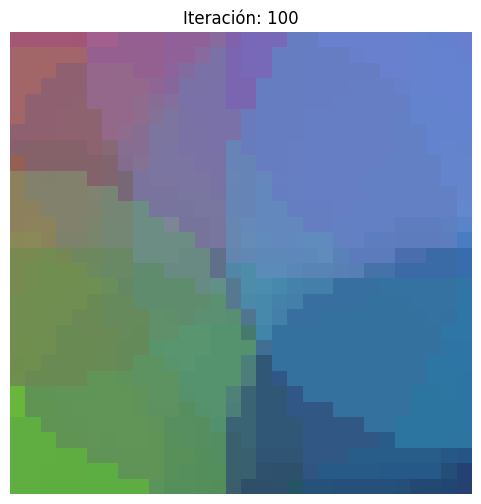

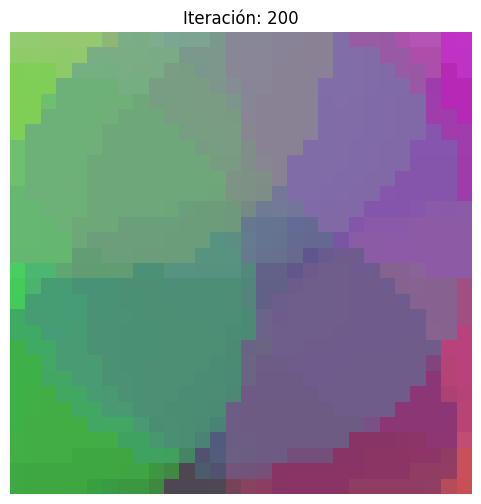

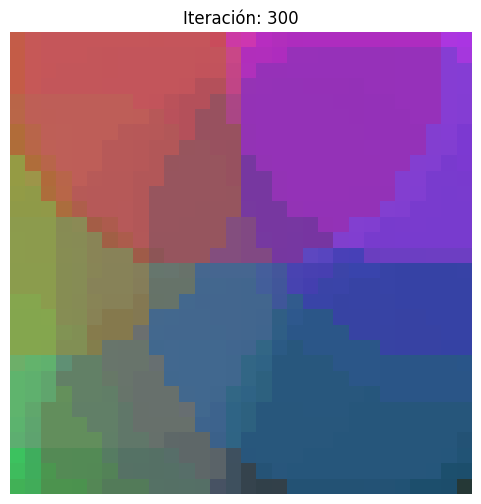

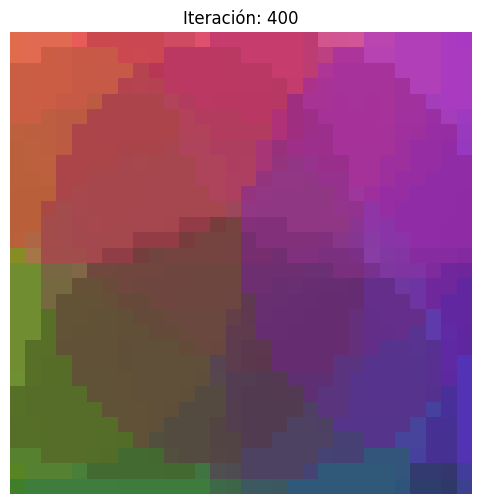

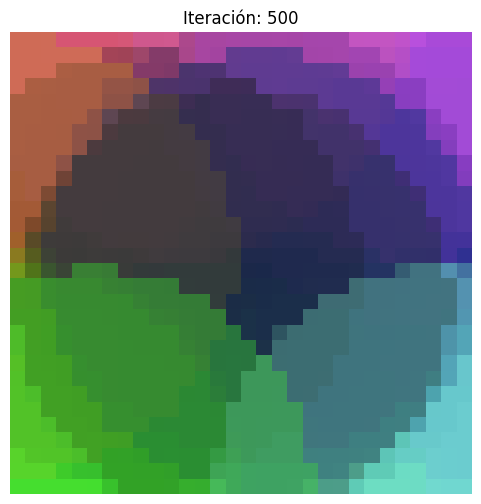

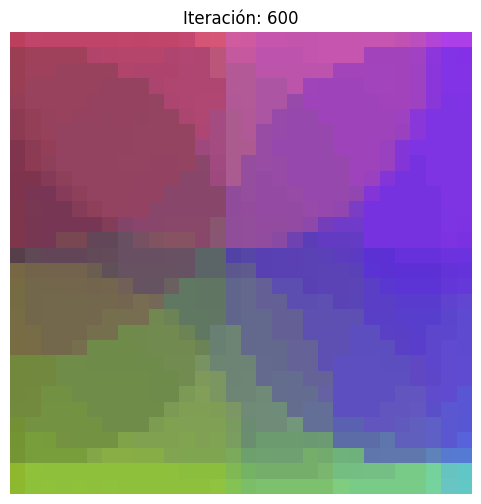

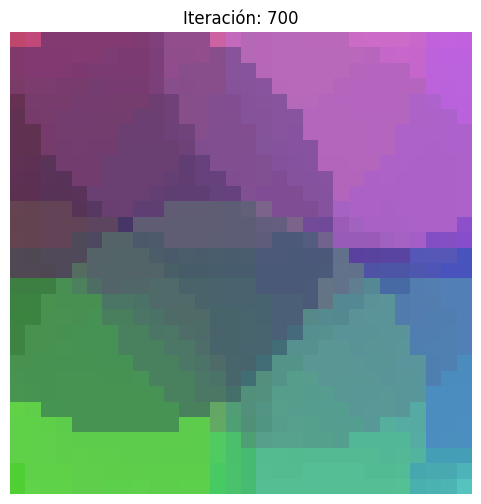

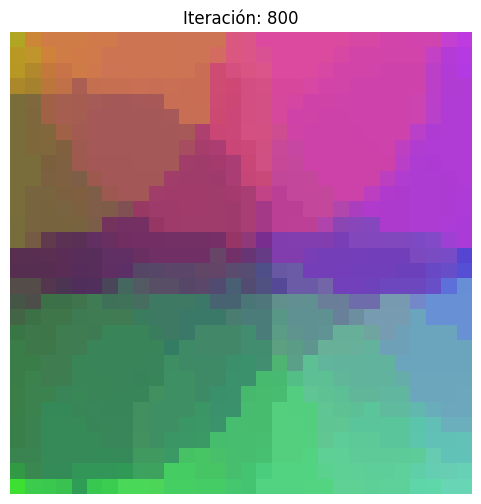

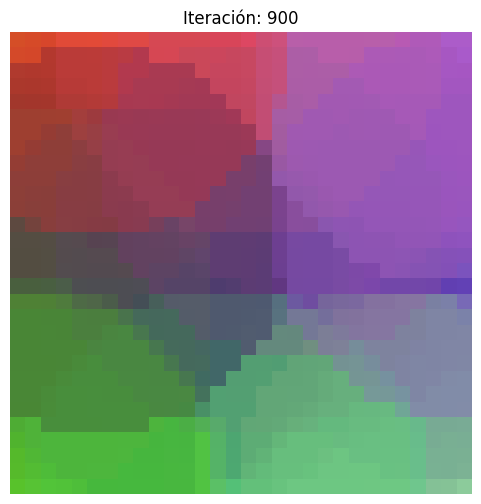

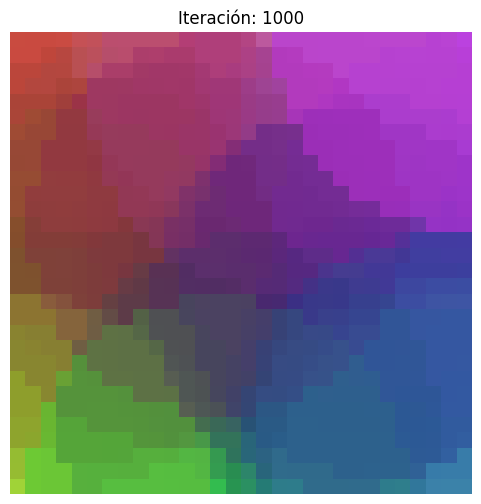

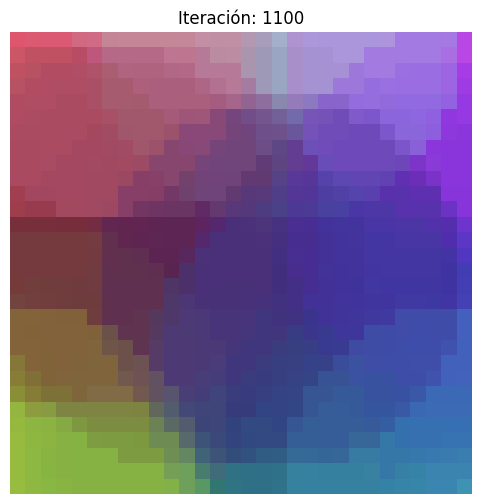

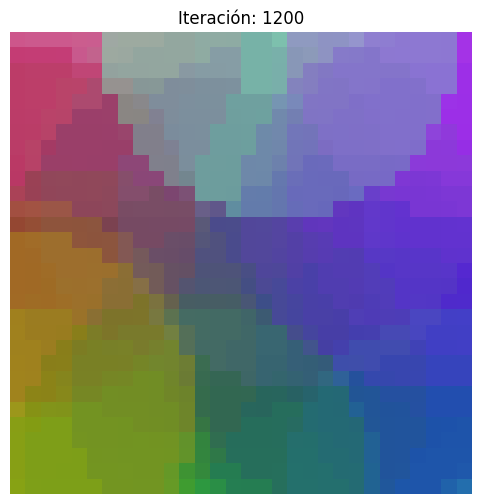

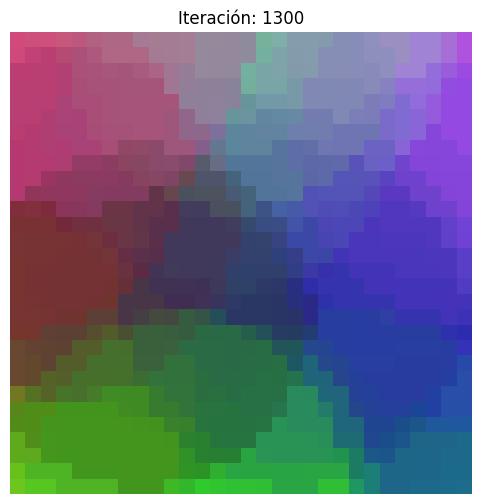

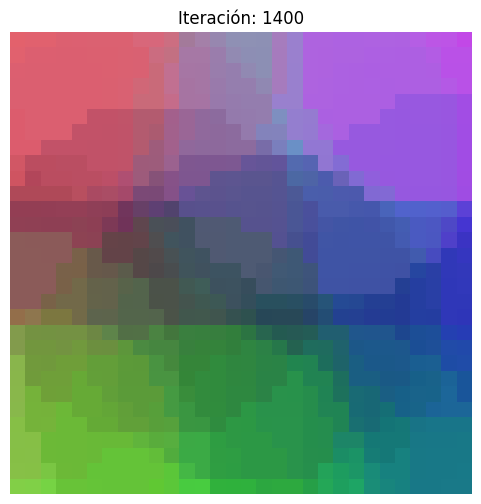

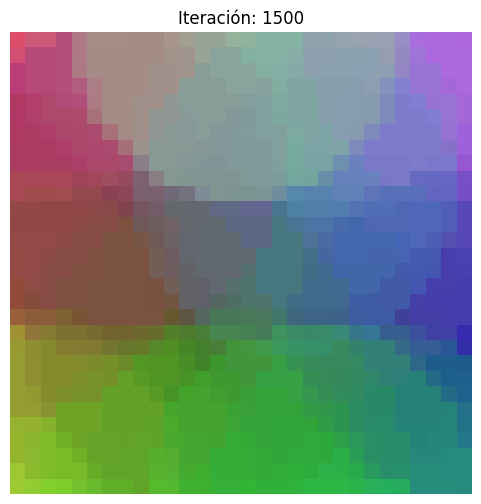

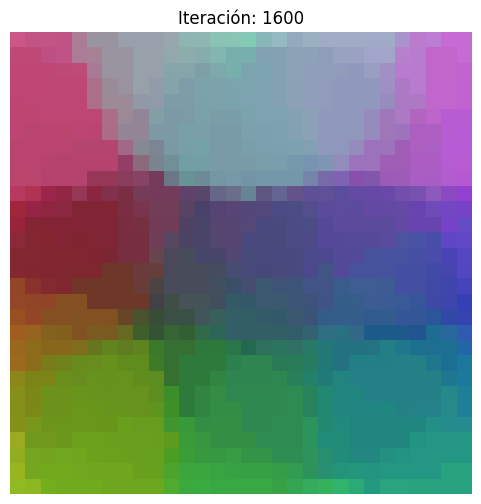

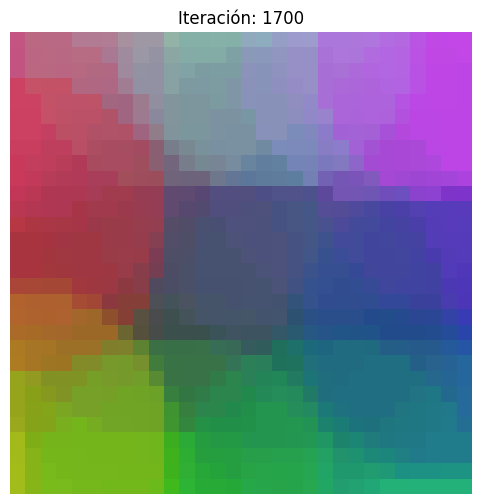

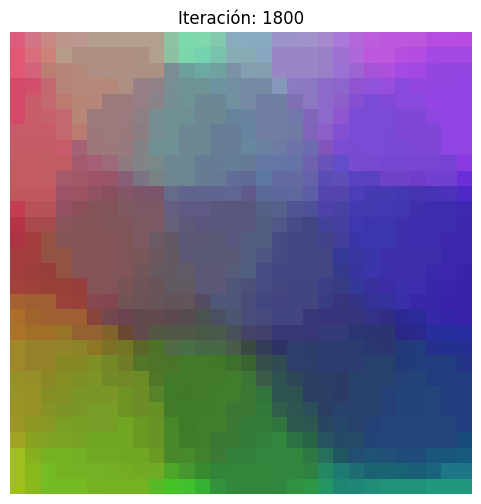

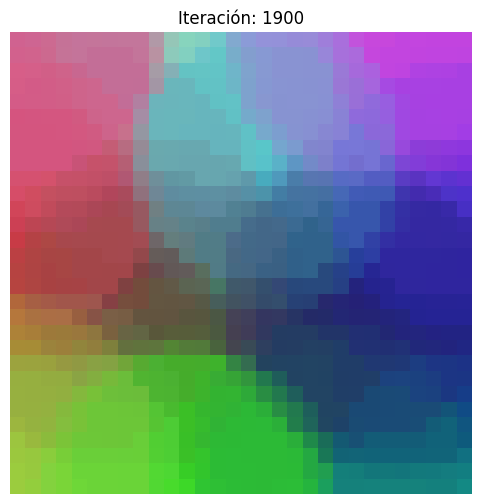

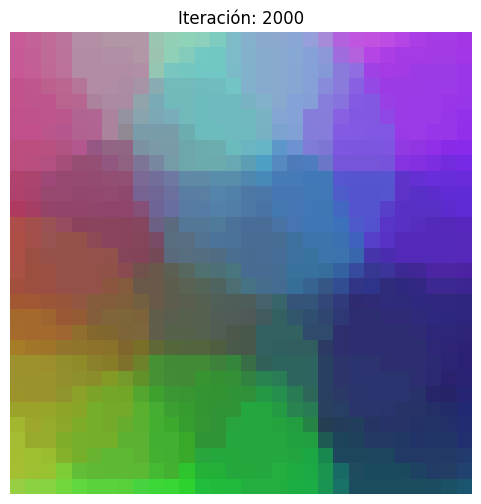

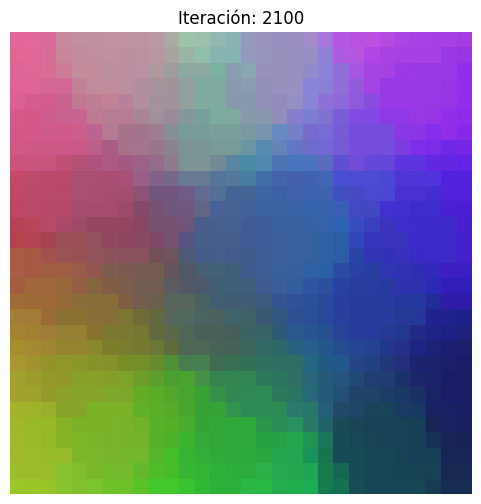

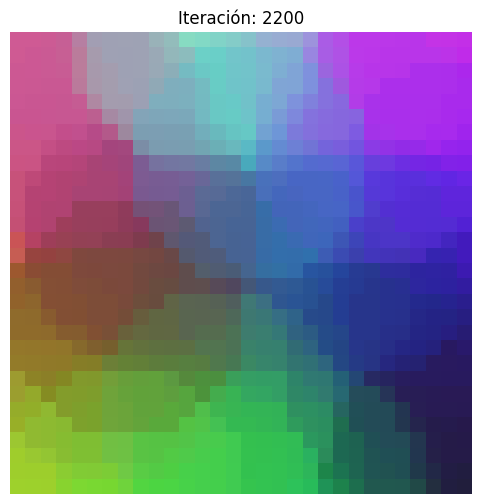

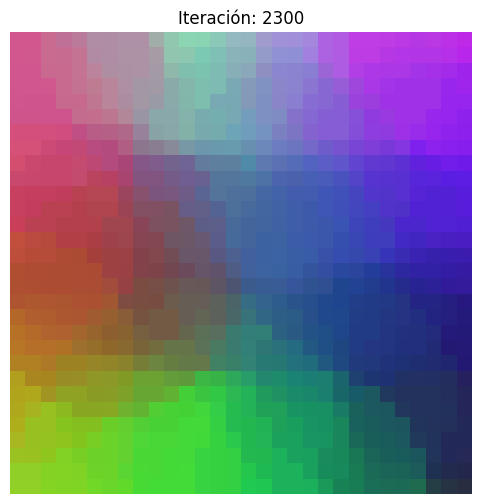

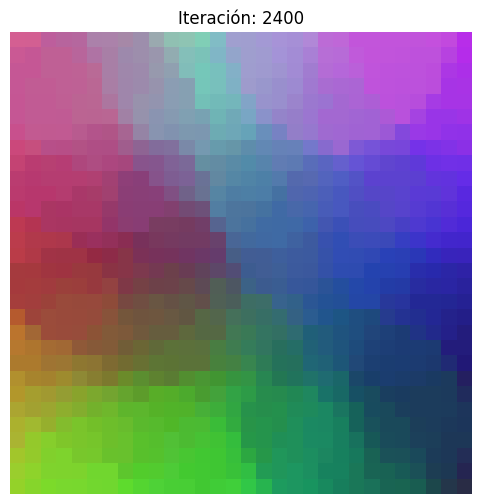

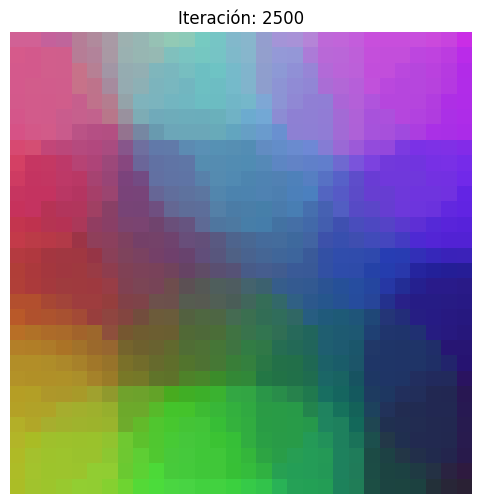

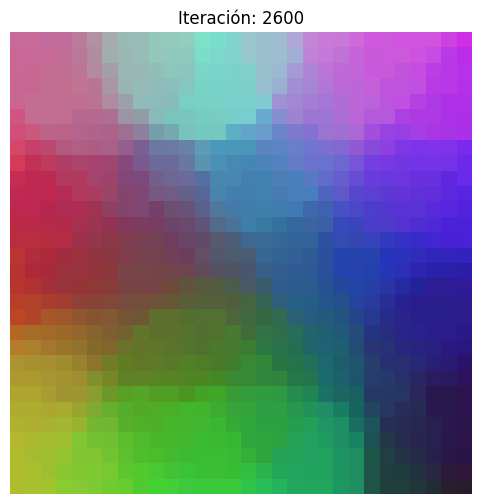

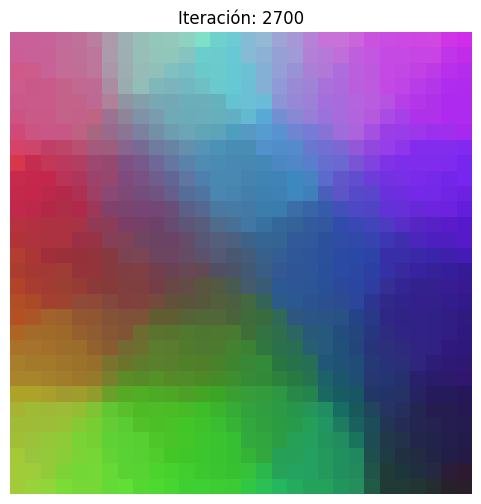

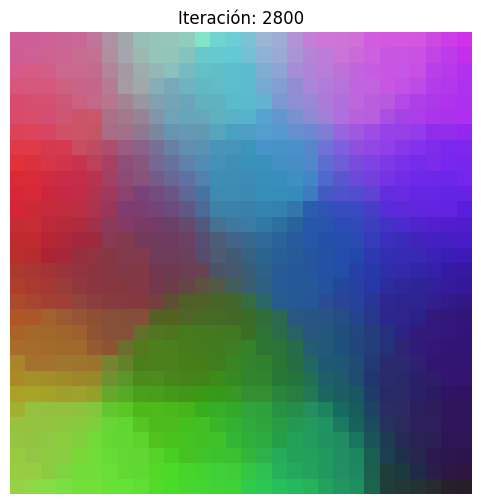

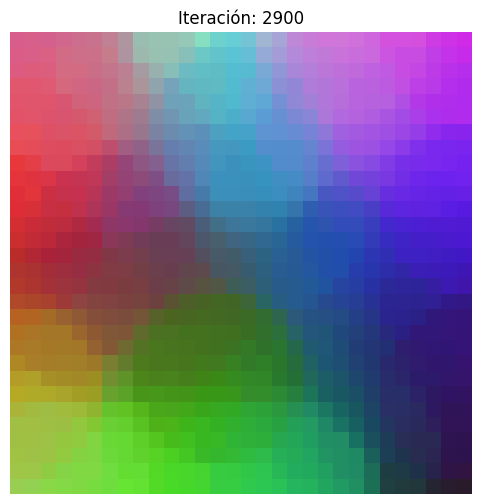

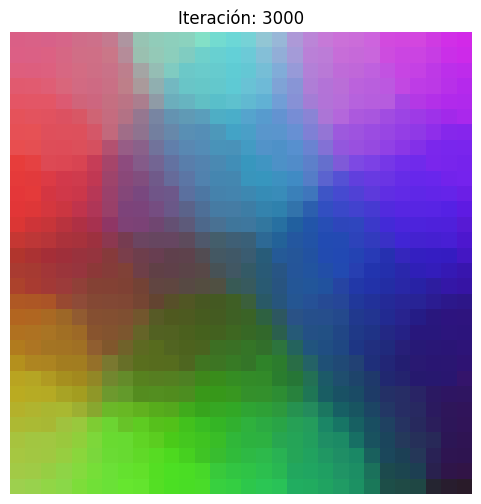

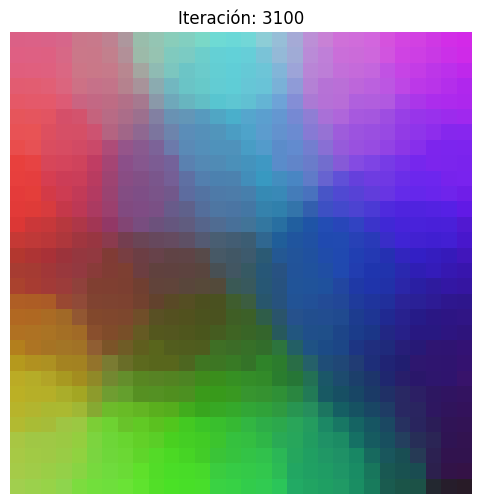

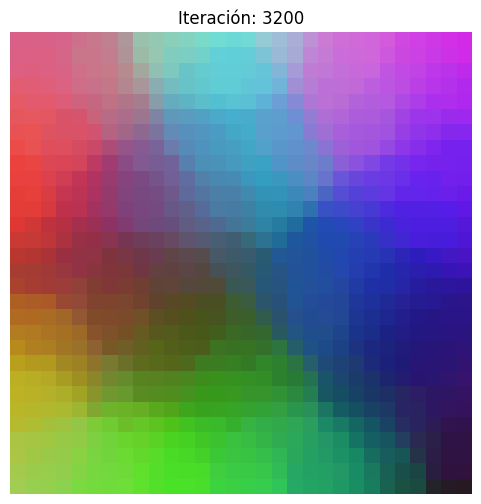

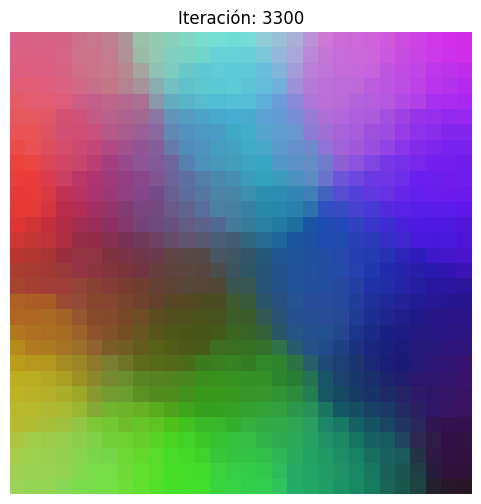

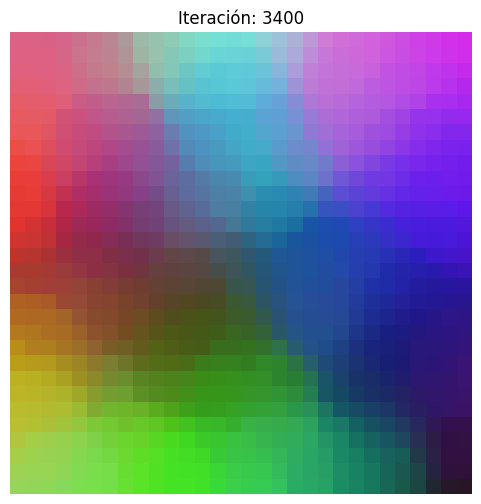

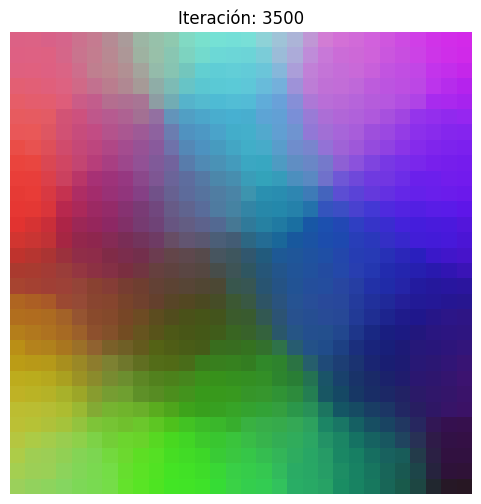

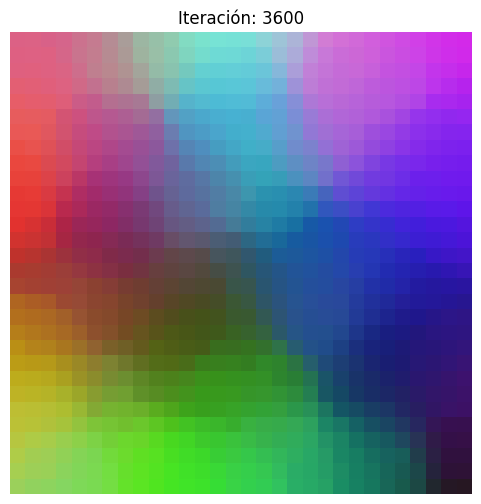

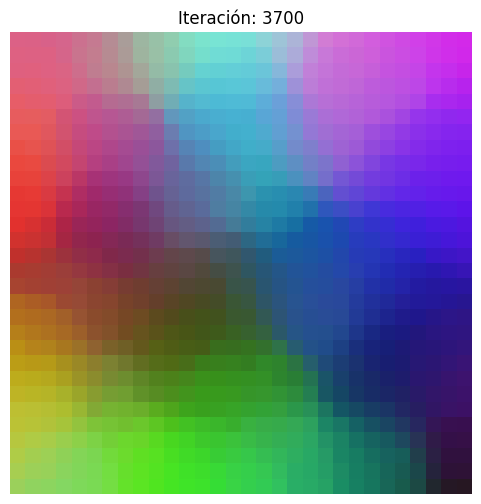

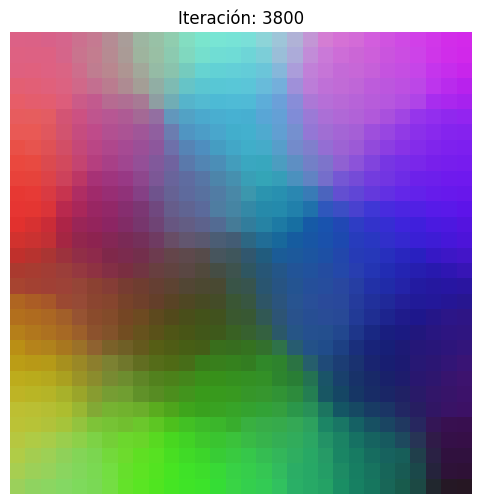

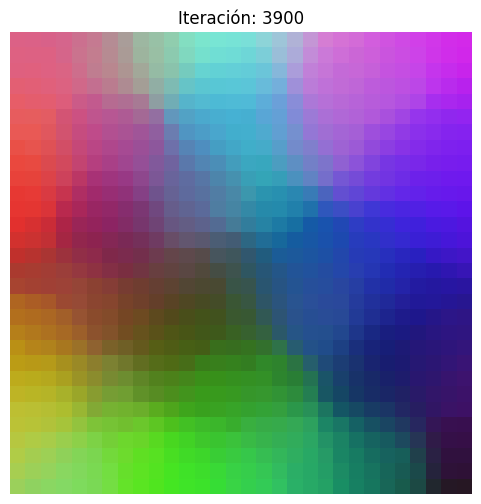

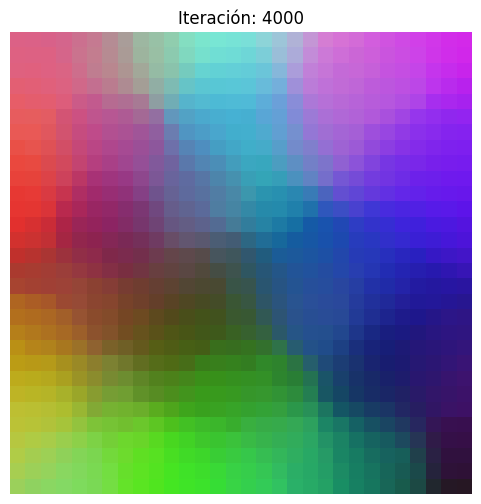

In [437]:
# Bucle principal

def calcular_error_cuantificacion(datos, matriz_pesos):
    error = 0
    for patron in datos:    
        bmu, bmu_idx, posicion = calcular_bmu(patron, matriz_pesos, num_entradas)
        error += np.linalg.norm(patron - matriz_pesos[posicion])
    return error / len(datos)

def es_vecino(bmu1_idx, bmu2_idx):
    x1, y1 = bmu1_idx
    x2, y2 = bmu2_idx
    return abs(x1 - x2) + abs(y1 - y2) == 1

def calcular_error_topologico(datos, matriz_pesos, lado_mapa):
    num_errores = 0

    for patron in datos:
        # Encontramos la BMU 
        bmu1, bmu1_idx, posicion1 = calcular_bmu(patron, matriz_pesos, num_entradas)
        
        # Encontraamos la segunda BMU, ignorando la BMU y guardando el índice de la segunda BMU
        distancias = np.linalg.norm(matriz_pesos - patron, axis=1)  # Distancias a todas las neuronas
        distancias[posicion1] = np.inf  
        posicion2 = np.argmin(distancias)  
        
        # Obtenemos las coordenadas (x, y) para la segunda BMU y si no es vecina de la BMU contamos como error
        bmu2_idx = (posicion2 // lado_mapa, posicion2 % lado_mapa)
        if not es_vecino(bmu1_idx, bmu2_idx):
            num_errores += 1

    # Promedio de errores sobre el total de datos
    return num_errores / len(datos)




#Listas para guardar los errores
errores_cuantificacion = []
errores_topologicos = []

for i in range(periodo+1):
    if i % 100 == 0:
        pintar_mapa(matriz_pesos, f"Iteración: {i}")
         # Calcular el error de cuantificación
        error_cuantificacion = calcular_error_cuantificacion(datos, matriz_pesos)
        errores_cuantificacion.append(error_cuantificacion)
        
        # Calcular el error topológico
        error_topologico = calcular_error_topologico(datos, matriz_pesos, lado_mapa)
        errores_topologicos.append(error_topologico)
    
    # Obtenemos el patrón de entrada ya normalizado
    patron_entrada = obtener_Entrada(datos)
    
    # Encontramos la bmu y calculamos eta y v
    bmu, bmu_idx, posicion = calcular_bmu(patron_entrada, matriz_pesos, num_entradas)
    eta = variacion_learning_rate(learning_rate, i, periodo)
    v = variacion_vecindario(vecindario, i, periodo)
    
    # Actualiza la matriz de pesos
    for j in range(len(matriz_pesos)):
        # Coordenadas de la neurona en la matriz
        x = j // lado_mapa
        y = j % lado_mapa
        
        # Calcula la distancia euclídea 2D respecto a la BMU
        distancia_BMU = np.sqrt((x - bmu_idx[0])**2 + (y - bmu_idx[1])**2)
        
        # Si está dentro del vecindario, actualizar pesos
        if distancia_BMU <= v:
            amortiguacion = decay(distancia_BMU, v)
            matriz_pesos[j] += eta * amortiguacion * (patron_entrada - matriz_pesos[j])



    

    



## SOM Clasificación

Número de clases: 97
Error de Cuantificación: 0.06584810279751473
Error Topológico: 0.2


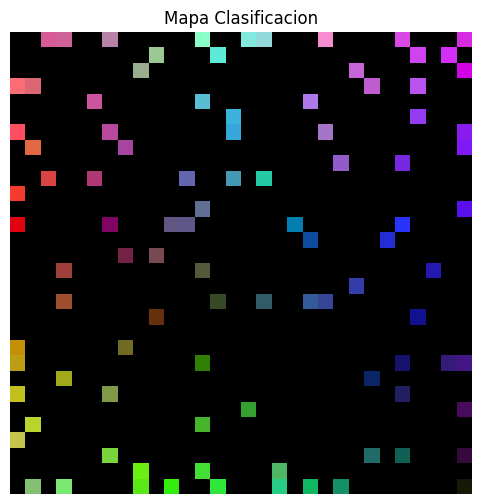

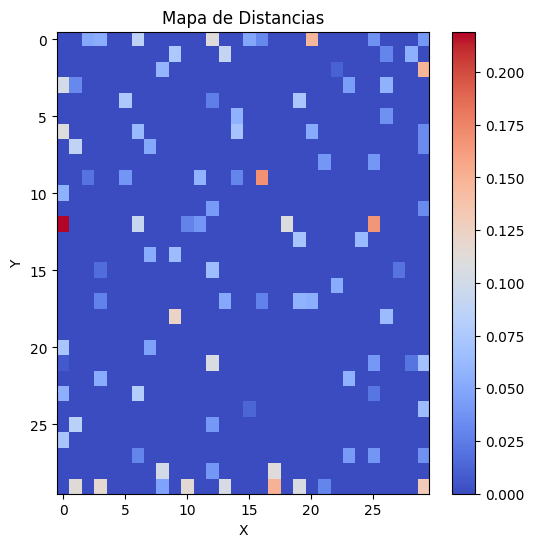

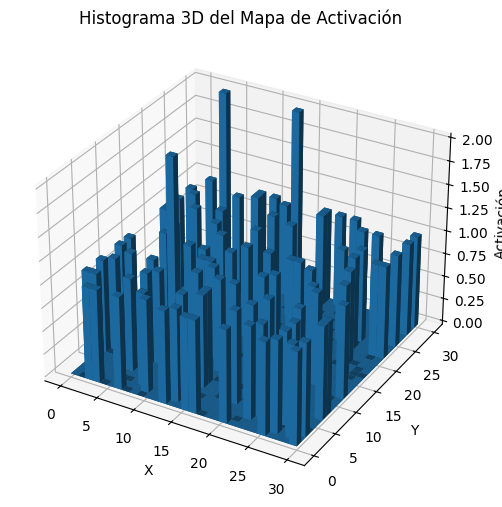

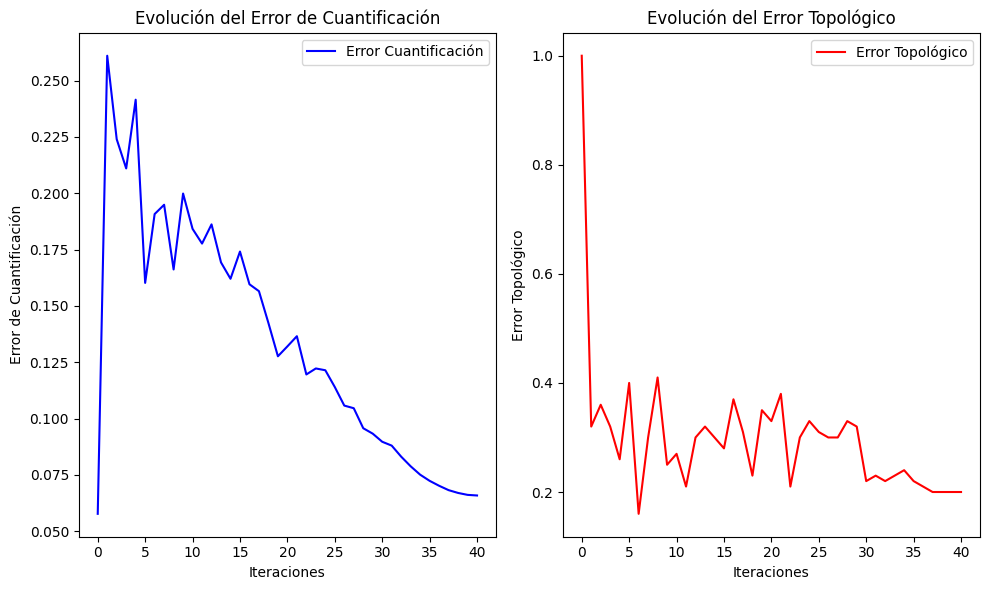

In [438]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada

# Inicializamos con 0 los mapas
mapa_clasificacion = np.zeros((lado_mapa*lado_mapa, num_entradas))
mapa_activacion = np.zeros((lado_mapa, lado_mapa))
mapa_distancias = np.zeros((lado_mapa, lado_mapa))
# Creamos una matriz auxiliar para acumular la suma de las distancias
suma_distancias = np.zeros((lado_mapa, lado_mapa))

for patron in datos:

    # Calculamos la bmu para cada patron del dataset y actualizamos el mapa de clasificación y el de activación
    bmu, bmu_idx, posicion = calcular_bmu(patron, matriz_pesos, num_entradas)

    mapa_clasificacion[posicion] = patron
    mapa_activacion[bmu_idx[0], bmu_idx[1]] += 1

    #Calculamos la distancia del patron a su bmu y se acumumla en la neurona correspondiente
    distancia = np.linalg.norm(patron - bmu)
    suma_distancias[bmu_idx[0], bmu_idx[1]] += distancia
    
    # Calculamos la distancia media solo para las neuronas activadas

for x in range(lado_mapa):
    for y in range(lado_mapa):
        if mapa_activacion[x, y] > 0:  # Solo calcular si la neurona fue activada
            mapa_distancias[x, y] = suma_distancias[x, y] / mapa_activacion[x, y]

# Las neuronas activadas son el número de clases, para calcularlas basta con contar las neuronas != de 0 en el mapa de activación
# Al tener una matriz con las distancias de los patrones a sus respectias BMUs basta con sumar dichas distancias y dividirlas por el 
# número de datos para hallar la media. De todas formas ya hemos implementado una función para hallar el error de cuantificación. 

num_clases = np.count_nonzero(mapa_activacion)
print("Número de clases:", num_clases)
error_cuantificacion = np.sum(suma_distancias) / len(datos)
print("Error de Cuantificación:", error_cuantificacion)
error_topologico = calcular_error_topologico(datos, matriz_pesos, lado_mapa)
print("Error Topológico:",error_topologico)

def pintar_graficas(mapa_1, mapa_2, mapa_3, lado_mapa):
    
    # Mapa de Clasificación
    pintar_mapa(mapa_1, 'Mapa Clasificacion')

    # Mapa de Distancias
    plt.figure(figsize=(6, 6))
    im3 = plt.imshow(mapa_3, cmap='coolwarm', aspect='auto')
    plt.title("Mapa de Distancias")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(im3)
    plt.show()

    # Mapa de Activación en 3D
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(np.arange(mapa_2.shape[0]), np.arange(mapa_2.shape[1]))
    x = x.flatten()
    y = y.flatten()
    z = mapa_2.flatten()

    ax.bar3d(x, y, np.zeros_like(z), 1, 1, z, shade=True, cmap='viridis')
    ax.set_title("Histograma 3D del Mapa de Activación")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Activación")
    plt.show()

def pintar_errores(e_cuantificacion, e_topologico):
    plt.figure(figsize=(10, 6))

    # Graficar error de cuantificación
    plt.subplot(1, 2, 1)
    plt.plot(e_cuantificacion, label='Error Cuantificación', color='blue')
    plt.xlabel('Iteraciones')
    plt.ylabel('Error de Cuantificación')
    plt.title('Evolución del Error de Cuantificación')
    plt.legend()

    # Graficar error topológico
    plt.subplot(1, 2, 2)
    plt.plot(e_topologico, label='Error Topológico', color='red')
    plt.xlabel('Iteraciones')
    plt.ylabel('Error Topológico')
    plt.title('Evolución del Error Topológico')
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()




pintar_graficas(mapa_clasificacion,mapa_activacion,mapa_distancias,lado_mapa)
pintar_errores(errores_cuantificacion, errores_topologicos)





## SOM Prueba

In [439]:
# Clasifica nuevos patrones

